In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re
import string
import gensim


In [9]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [121]:
import os
import random
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  # tf.random.set_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

In [3]:
# def preprocess(sentences):
#   tweet_list = []
#   filter = string.ascii_letters + " "
#   lm = WordNetLemmatizer()
#   for tweet in sentences:
#     tweet_cleaned = re.sub(r'http\S+', '', tweet)
#     tweet_cleaned = "".join([chr for chr in tweet_cleaned if chr in filter])
#     tweet_cleaned = tweet_cleaned.lower()
#     tokens = word_tokenize(tweet_cleaned)
#     clean_list = [word for word in tokens if word not in stopwords.words('english')]
#     clean_list = [lm.lemmatize(word) for word in clean_list]
#     tweet_cleaned = " ".join(clean_list)
#     tweet_list.append(tweet_cleaned)

#   return np.array(tweet_list)

In [11]:
import re
import string
# from spellchecker import SpellChecker
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pandas as pd
import spacy
from nltk.stem import WordNetLemmatizer

# Defining acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

# Defining contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

# Defining stopwords
nlp_stopwords = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(nlp.Defaults.stop_words)
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe", "ï", "ûï"]
stops = nlp_stopwords + spacy_stopwords + alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others
stops = list(set(stops))

# Defining tokenizer
regexp = RegexpTokenizer("[\w']+")

# Defining spellchecker
# spell = SpellChecker()

# Preprocessing
def preprocess(text):
    
    text = text.lower()                                                                                        # lowercase
    text = text.strip()                                                                                        # whitespaces
    
    # Removing html tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)                                                                                 # html tags
    
    # Removing emoji patterns
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', text)                                                                         # unicode char
    
    # Removing urls
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    text = re.sub(pattern, "", text)                                                                            # remove urls
    
    # Removing twitter usernames
    pattern = r'@[\w_]+'
    text = re.sub(pattern, "", text)                                                                            # remove @twitter usernames
    
    # Removing punctuations and numbers
    punct_str = string.punctuation + string.digits
    punct_str = punct_str.replace("'", "")
    punct_str = punct_str.replace("-", "")
    text = text.translate(str.maketrans('', '', punct_str))                                                     # punctuation and numbers
    
    # Replacing "-" in text with empty space
    text = text.replace("-", " ")                                                                               # "-"
    
    # Substituting acronyms
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_dict.index:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()
    text = ' '.join(words)                                                                                       # acronyms
    
    # Substituting Contractions
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_dict.index:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    text = " ".join(words)                                                                                       # contractions
    
    punct_str = string.punctuation
    text = text.translate(str.maketrans('', '', punct_str))                                                     # punctuation again to remove "'"
    
    # # Spellchecker
    # word_list = regexp.tokenize(text)
    # word_list_corrected = []
    # for word in word_list:
    #     if word in spell.unknown(word_list):
    #         word_corrected = spell.correction(word)
    #         if word_corrected == None:
    #             word_list_corrected.append(word)
    #         else:
    #             word_list_corrected.append(word_corrected)
    #     else:
    #         word_list_corrected.append(word)
    # text = " ".join(word_list_corrected)                                                                        # spellchecker
    

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in regexp.tokenize(text)])                             # lemmatize
    
    # Stopwords Removal
    text = ' '.join([word for word in regexp.tokenize(text) if word not in stops])                              # stopwords
    
    # Removing all characters except alphabets and " " (space)
    filter = string.ascii_letters + " "
    text = "".join([chr for chr in text if chr in filter])                                                      # remove all characters except alphabets and " " (space)
    
    # Removing words with one alphabet occuring more than 3 times continuously
    pattern = r'\b\w*?(.)\1{2,}\w*\b'
    text = re.sub(pattern, "", text).strip()                                                                    # remove words with one alphabet occuring more than 3 times continuously
    
    # Removing words with less than 3 characters
    short_words = r'\b\w{1,2}\b'
    text = re.sub(short_words, "", text)                                                                     # remove words with less than 3 characters
    
    # return final output
    return text


In [12]:
# preprocess data
df["text_clean"] = df["text"].apply(lambda x: preprocess(x))

In [13]:
df.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [14]:
df["text_clean"].duplicated().sum()

860

In [16]:
# drop duplicates
df["text"].duplicated().sum()
df.drop_duplicates(subset = ["text_clean"], inplace = True)

In [17]:
X = df["text_clean"]
y = df["target"]

In [103]:
# Spliting into train and test
from sklearn.model_selection import train_test_split

X_train, X_text, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=3)
print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of X_text is {X_text.shape}")
print(f"Shape of y_train is {y_train.shape}")
print(f"Shape of y_test is {y_test.shape}")

Shape of X_train is (5402,)
Shape of X_text is (1351,)
Shape of y_train is (5402,)
Shape of y_test is (1351,)


In [104]:
X_train.head()

1610    ash australia totally collapse internet absolu...
3838    new giant flame giant black pantofel infoorder...
274                           jocelyn birthday apocalypse
6072    water main break disrupts trolley service sand...
2155    fco minister condemns attack mosque saudi arab...
Name: text_clean, dtype: object

In [105]:
tweet_len = []
for tweet in X_train:
    tweet_len.append(len(tweet.split()))
    
pd.Series(tweet_len).describe()

count    5402.000000
mean        7.604406
std         3.199056
min         0.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        21.000000
dtype: float64

<Axes: ylabel='Density'>

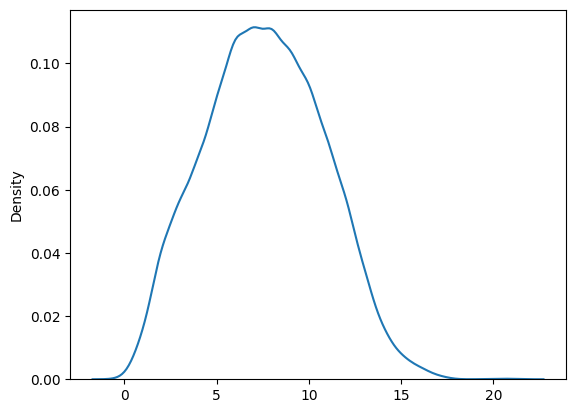

In [106]:
sns.kdeplot(tweet_len)

In [107]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=12) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [108]:
# This work same as .fit
text_vectorizer.adapt(X_train)

In [109]:
import random

random.choice(range(len(X_train)))

4404

In [110]:
import random 
random_index = random.choice(range(len(X_train)))
tweet = X_train.iloc[random_index]
print(tweet)

text_vectorizer(tweet)

day remember nuclear weapon powerhiroshima 


<tf.Tensor: shape=(12,), dtype=int64, numpy=
array([   9,  321,   34,   46, 6427,    0,    0,    0,    0,    0,    0,
          0], dtype=int64)>

In [111]:
text_vectorizer("hjgfhjdg djshflihlkjdsaf")

<tf.Tensor: shape=(12,), dtype=int64, numpy=array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)>

In [112]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab)

10932

In [113]:
words_in_vocab[-1000:]

['chrissie',
 'chpsre',
 'chowchilla',
 'choudary',
 'chose',
 'chore',
 'chord',
 'chopras',
 'chopping',
 'choppergatebronwynbishopauspol',
 'chopped',
 'choppas',
 'choosegod',
 'choked',
 'choke',
 'choctaw',
 'chitral',
 'chippewa',
 'chipper',
 'chim',
 'chillin',
 'chilli',
 'childsexabuse',
 'childress',
 'childish',
 'childhooddefined',
 'childfund',
 'childcare',
 'chieftain',
 'chick',
 'chicagoscanner',
 'chiasson',
 'chiang',
 'cheyenne',
 'chew',
 'chester',
 'cher',
 'chemically',
 'chem',
 'chelsea',
 'chef',
 'cheetos',
 'cheekiness',
 'checkout',
 'checking',
 'checkedhe',
 'cheated',
 'che',
 'chawalchorbjp',
 'chaser',
 'chartreuse',
 'charred',
 'charon',
 'charming',
 'charmeuse',
 'charmed',
 'charlize',
 'charlies',
 'charleston',
 'chargedup',
 'chapter',
 'chann',
 'chaning',
 'changing',
 'changefortheworse',
 'chandrababu',
 'chandanee',
 'chan',
 'championsblackfoot',
 'champion',
 'champaign',
 'champagne',
 'challenging',
 'chalked',
 'chainsaw',
 'chachi

In [114]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10932
Top 5 most common words: ['', '[UNK]', 'fire', 'amp', 'new']
Bottom 5 least common words: ['aashiqui', 'aar', 'aan', 'aampw', 'aal']


In [115]:
# Defining En=mbedding layer

from tensorflow.keras import layers
max_vocab_length = len(text_vectorizer.get_vocabulary())
max_length = 12
embedding = layers.Embedding(input_dim= max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize uniform
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [116]:
embedding(text_vectorizer(tweet))

<tf.Tensor: shape=(12, 128), dtype=float32, numpy=
array([[-0.00650947, -0.04132035,  0.04360092, ...,  0.01558889,
        -0.04969503,  0.00218894],
       [-0.02418371, -0.01004896,  0.00079895, ..., -0.00134243,
        -0.02468299,  0.00213651],
       [-0.0166814 ,  0.00607324, -0.03708785, ...,  0.04011408,
        -0.00858576,  0.03788164],
       ...,
       [ 0.04509784,  0.02552154,  0.00977451, ..., -0.03899961,
         0.02829666,  0.0373098 ],
       [ 0.04509784,  0.02552154,  0.00977451, ..., -0.03899961,
         0.02829666,  0.0373098 ],
       [ 0.04509784,  0.02552154,  0.00977451, ..., -0.03899961,
         0.02829666,  0.0373098 ]], dtype=float32)>

In [117]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=12) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

text_vectorizer.adapt(X_train)



In [128]:
# Simple RNN model

set_seed(3)


from tensorflow.keras import layers
max_vocab_length = len(text_vectorizer.get_vocabulary())
max_length = 12
embedding_rnn = layers.Embedding(input_dim= max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize uniform
                             input_length=max_length, # how long is each input
                             name="embedding_1")



model_rnn = tf.keras.models.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    text_vectorizer,
    embedding_rnn,
    layers.Dropout(0.5),
    layers.SimpleRNN(6, activation="tanh", return_sequences=True, recurrent_dropout=0.3, kernel_regularizer="l1", recurrent_regularizer="l1"),
    layers.SimpleRNN(6, activation="tanh"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])


model_rnn.summary()

Random seed set as 3
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_9 (Text  (None, 12)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 12, 128)           1399296   
                                                                 
 dropout_4 (Dropout)         (None, 12, 128)           0         
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 12, 6)             810       
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 6)                 78        
                                                                 
 dropout_5 (Dropout)         (None, 6)                 0         
                                 

In [129]:
# Model Compling
set_seed(3)

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

result = model_rnn.fit(X_train, y_train, epochs=15, batch_size=40, validation_data=(X_text, y_test))



Random seed set as 3
Epoch 1/15
136/136 [==============================] - 7s 28ms/step - loss: 1.3085 - accuracy: 0.5296 - val_loss: 1.0157 - val_accuracy: 0.5862
Epoch 2/15
136/136 [==============================] - 3s 25ms/step - loss: 0.8631 - accuracy: 0.5918 - val_loss: 0.7731 - val_accuracy: 0.5862
Epoch 3/15
136/136 [==============================] - 3s 22ms/step - loss: 0.7568 - accuracy: 0.5909 - val_loss: 0.7470 - val_accuracy: 0.5862
Epoch 4/15
136/136 [==============================] - 3s 23ms/step - loss: 0.7360 - accuracy: 0.5909 - val_loss: 0.7272 - val_accuracy: 0.5862
Epoch 5/15
136/136 [==============================] - 3s 24ms/step - loss: 0.7174 - accuracy: 0.5909 - val_loss: 0.7090 - val_accuracy: 0.5862
Epoch 6/15
136/136 [==============================] - 3s 22ms/step - loss: 0.7001 - accuracy: 0.5909 - val_loss: 0.6954 - val_accuracy: 0.5862
Epoch 7/15
136/136 [==============================] - 3s 23ms/step - loss: 0.6903 - accuracy: 0.5909 - val_loss: 0.6866 -

In [ ]:
# Simple LSTM model

set_seed(3)


from tensorflow.keras import layers
max_vocab_length = len(text_vectorizer.get_vocabulary())
max_length = 12
embedding_rnn = layers.Embedding(input_dim= max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize uniform
                             input_length=max_length, # how long is each input
                             name="embedding_1")



model_lstm = tf.keras.models.Sequential([
    layers.Input(shape=(1,), dtype="string"),
    text_vectorizer,
    embedding_rnn,
    layers.Dropout(0.5),
    layers.LSTM(6, activation="tanh", return_sequences=True, recurrent_dropout=0.3, kernel_regularizer="l1", recurrent_regularizer="l1"),
    layers.LSTM(6, activation="tanh"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])


model_lstm.summary()